In [ ]:
!gdown 1xfd9hj94Sbz2cxl17JcyxTU-hBz2JvG3

Downloading...
From: https://drive.google.com/uc?id=1xfd9hj94Sbz2cxl17JcyxTU-hBz2JvG3
To: /content/FPT_train.csv
100% 55.3k/55.3k [00:00<00:00, 58.3MB/s]


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
import random

#Seed setting
def set_seed(seed=8820):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(8820)

In [ ]:
# ===== CONFIGURATION PARAMETERS =====
INPUT_LEN = 14               # Number of input days
OUTPUT_LEN = 3               # Number of output days per prediction step
TOTAL_PREDICT_DAYS = 100     # Total number of days to forecast

In [ ]:
# ===== LOAD DATA =====
df_train = pd.read_csv('FPT_train.csv')
df_train['time'] = pd.to_datetime(df_train['time'])
df_train = df_train.sort_values('time').reset_index(drop=True)

# ===== FEATURE ENGINEERING =====

# 1. Log-transform price features
df_train['log_open'] = np.log(df_train['open'])
df_train['log_high'] = np.log(df_train['high'])
df_train['log_low'] = np.log(df_train['low'])
df_train['log_close'] = np.log(df_train['close'])

# 2. Returns
df_train['daily_return'] = df_train['close'].pct_change()
df_train['log_return'] = np.log(df_train['close'] / df_train['close'].shift(1))

# 3. 7-day Moving Average
df_train['ma_7'] = df_train['close'].rolling(7).mean()
df_train['close_ma7_ratio'] = df_train['close'] / df_train['ma_7']

# ===== REMOVE NaN ROWS =====
df_train = df_train.dropna().reset_index(drop=True)

# Define feature columns
# (volume excluded because its magnitude is too large and may introduce bias)
FEATURE_COLS = [
    'log_open',
    'log_high',
    'log_low',
    'log_close',
    'daily_return',
    'log_return',
    'close_ma7_ratio'
]

TARGET_COL = 'log_return'

# ===== VALIDATION CHECK =====
print(f"Train data shape: {df_train.shape}")
print(f"Number of features: {len(FEATURE_COLS)}")
print(f"Features: {FEATURE_COLS}\n")

print("Last 10 rows:")
print(df_train[['time', 'close', 'log_return', 'close_ma7_ratio']].tail(10))

print("\nFeature statistics:")
print(df_train[FEATURE_COLS].describe())


Train data shape: (1143, 15)
Number of features: 7
Features: ['log_open', 'log_high', 'log_low', 'log_close', 'daily_return', 'log_return', 'close_ma7_ratio']

Last 10 rows:
           time   close  log_return  close_ma7_ratio
1133 2025-02-25  119.85   -0.010706         0.976932
1134 2025-02-26  122.26    0.019909         0.998378
1135 2025-02-27  121.83   -0.003523         0.997474
1136 2025-02-28  120.97   -0.007084         0.994142
1137 2025-03-03  121.14    0.001404         0.998070
1138 2025-03-04  120.71   -0.003556         0.996544
1139 2025-03-05  119.93   -0.006483         0.991520
1140 2025-03-06  122.09    0.017850         1.006714
1141 2025-03-07  121.92   -0.001393         1.005715
1142 2025-03-10  120.11   -0.014957         0.992797

Feature statistics:
          log_open     log_high      log_low    log_close  daily_return  \
count  1143.000000  1143.000000  1143.000000  1143.000000   1143.000000   
mean      4.023261     4.034211     4.012985     4.023898      0.001700 

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             1143 non-null   datetime64[ns]
 1   open             1143 non-null   float64       
 2   high             1143 non-null   float64       
 3   low              1143 non-null   float64       
 4   close            1143 non-null   float64       
 5   volume           1143 non-null   int64         
 6   symbol           1143 non-null   object        
 7   log_open         1143 non-null   float64       
 8   log_high         1143 non-null   float64       
 9   log_low          1143 non-null   float64       
 10  log_close        1143 non-null   float64       
 11  daily_return     1143 non-null   float64       
 12  log_return       1143 non-null   float64       
 13  ma_7             1143 non-null   float64       
 14  close_ma7_ratio  1143 non-null   float64

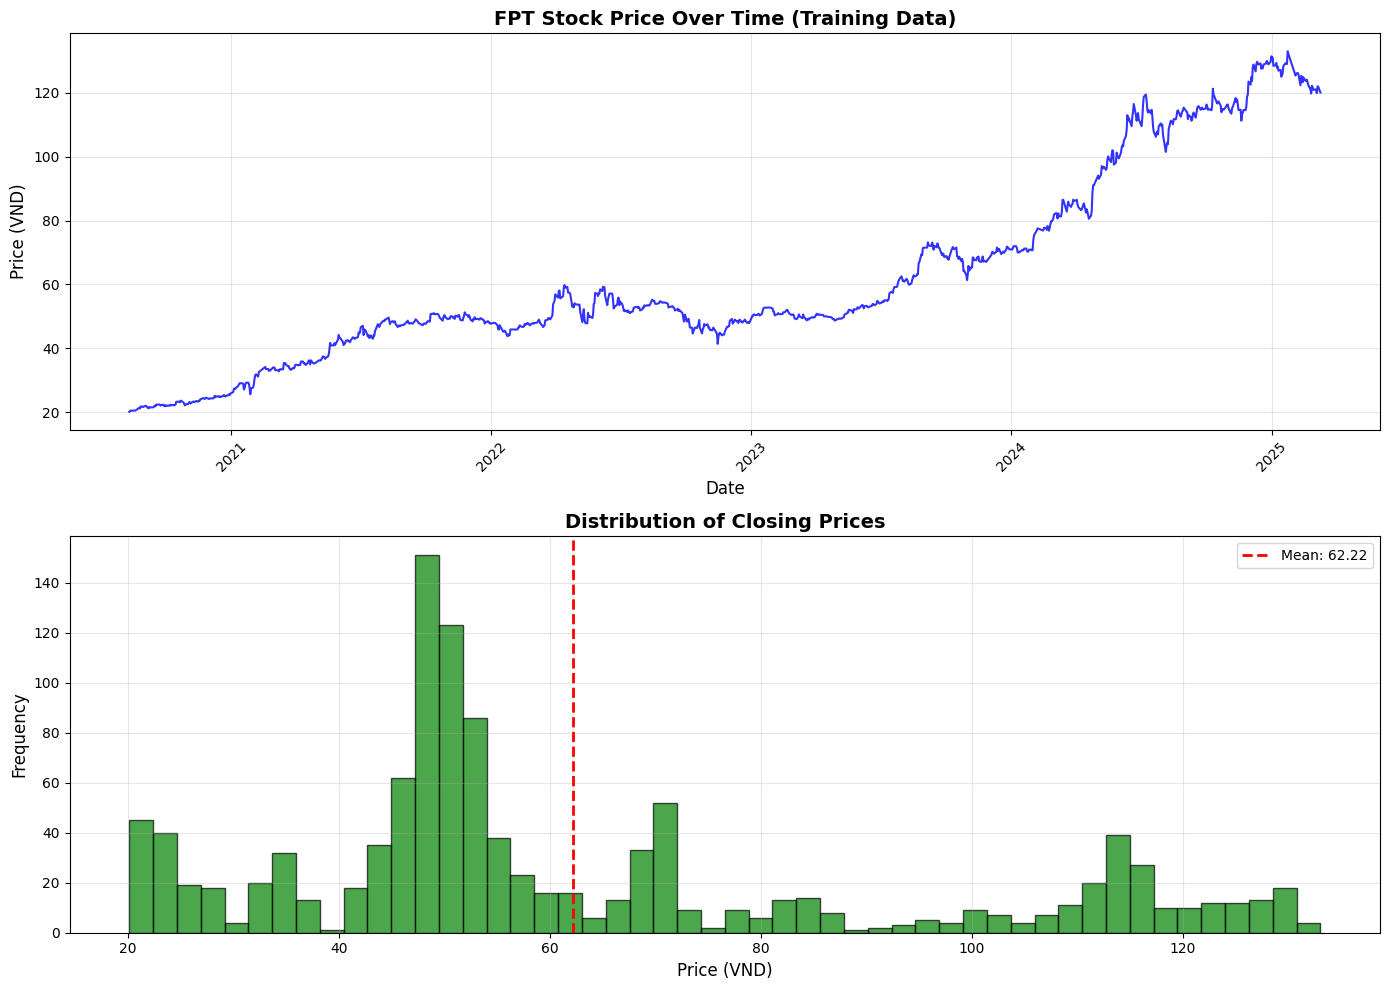

In [ ]:
# ===== DATA ANALYSIS =====
# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Closing price over time
axes[0].plot(df_train['time'], df_train['close'], linewidth=1.5, color='blue', alpha=0.8)
axes[0].set_title('FPT Stock Price Over Time (Training Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price (VND)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Price distribution
axes[1].hist(df_train['close'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Closing Prices', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Price (VND)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(
    df_train['close'].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Mean: {df_train["close"].mean():.2f}'
)
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
class Linear(nn.Module):
    def __init__(self, input_len, output_len, num_features):
        super(Linear, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.num_features = num_features

        # Flatten input
        self.linear = nn.Linear(input_len * num_features, output_len)

    def forward(self, x):
        # x: [batch, input_len, num_features] = [batch, 14, 7]
        batch_size = x.shape[0]

        # Flatten
        x_flat = x.reshape(batch_size, -1)  # [batch, 98]

        # Linear
        out = self.linear(x_flat)  # [batch, 1]

        return out

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, output_len, feature_cols, target_col='log_return'):
        """
        Args:
            data (DataFrame): The input dataframe.
            input_len (int): Number of input days (e.g., 14).
            output_len (int): Number of output days per sample (e.g., 1 or 3).
            feature_cols (list): List of feature column names (7 features).
            target_col (str): Name of the target column (default: 'log_return').
        """
        self.data_X = data[feature_cols].values  # Shape: [N, num_features]
        self.data_y = data[target_col].values    # Shape: [N]
        self.input_len = input_len
        self.output_len = output_len
        self.num_features = len(feature_cols)

    def __len__(self):
        # Total valid samples = N - input_len - output_len + 1
        return len(self.data_X) - self.input_len - self.output_len + 1

    def __getitem__(self, idx):
        # X shape: [input_len, num_features] = e.g., [14, 7]
        x = self.data_X[idx : idx + self.input_len]

        # y shape: [output_len] = e.g., [1] or [3]
        y = self.data_y[idx + self.input_len : idx + self.input_len + self.output_len]

        return torch.FloatTensor(x), torch.FloatTensor(y)


# ===== CREATE DATASET =====

dataset = TimeSeriesDataset(
    df_train,
    INPUT_LEN,
    OUTPUT_LEN,
    feature_cols=FEATURE_COLS,   # 7 features
    target_col=TARGET_COL        # log_return
)

train_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# ===== VALIDATION CHECKS =====
print(f"Dataset size: {len(dataset)} samples")
print(f"Input shape: [{INPUT_LEN}, {dataset.num_features}]")
print(f"Output shape: [{OUTPUT_LEN}]")

# Test a single sample
sample_x, sample_y = dataset[0]
print(f"\nSample X shape: {sample_x.shape}")  # Expected: [14, 7]
print(f"Sample y shape: {sample_y.shape}")    # Expected: [1]


Dataset size: 1127 samples
Input shape: [14, 7]
Output shape: [3]

Sample X shape: torch.Size([14, 7])
Sample y shape: torch.Size([3])


In [ ]:
def train_model(model, train_loader, num_epochs=50, lr=0.001):
    """
    Args:
        model: PyTorch model instance.
        train_loader: DataLoader for training data.
        num_epochs (int): Number of training epochs.
        lr (float): Initial learning rate.

    Returns:
        model: Trained model.
        history (dict): Dictionary containing training loss history.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Scheduler: reduces LR when training loss plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    train_losses = []
    prev_lr = lr

    print("=" * 60)
    print(f"{'Epoch':<10} {'Train Loss':<20} {'Status':<20}")
    print("=" * 60)

    for epoch in range(num_epochs):
        # ============ TRAINING LOOP ============
        model.train()
        epoch_loss = 0.0

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Adjust learning rate based on training loss
        scheduler.step(avg_train_loss)

        # Check if LR has changed
        current_lr = optimizer.param_groups[0]['lr']
        status = ""
        if current_lr < prev_lr:
            status = f"→ LR reduced to {current_lr:.2e}"
            prev_lr = current_lr

        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"{epoch + 1:<10} {avg_train_loss:<20.6f} {status:<20}")

    print("=" * 60)
    print("✅ Training completed!\n")

    history = {
        'train_losses': train_losses
    }

    return model, history


In [ ]:
# ============================================
# TRAINING PIPELINE
# ============================================

# Create dataset
full_dataset = TimeSeriesDataset(
    df_train,
    INPUT_LEN,
    OUTPUT_LEN,
    feature_cols=FEATURE_COLS,
    target_col=TARGET_COL
)

train_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

print(f"Total training samples: {len(full_dataset)}")
print(f"Input shape: [{INPUT_LEN}, {full_dataset.num_features}]")
print(f"Output shape: [{OUTPUT_LEN}]\n")

# Train model
print("=" * 70)
print("TRAINING LINEAR MODEL")
print("=" * 70)

linear_model = Linear(INPUT_LEN, OUTPUT_LEN, num_features=len(FEATURE_COLS))

trained_linear, linear_history = train_model(
    linear_model,
    train_loader,
    num_epochs=50,
    lr=0.001
)

print("\n✅ Training completed!")
print(f"✅ Final training loss: {linear_history['train_losses'][-1]:.6f}\n")


Total training samples: 1127
Input shape: [14, 7]
Output shape: [3]

TRAINING LINEAR MODEL
Using device: cpu

Epoch      Train Loss           Status              
1          0.177830                                 
5          0.003291                                 
10         0.001908                                 
15         0.001888                                 
20         0.001768                                 
25         0.001453                                 
30         0.001172                                 
35         0.001031                                 
40         0.000954                                 
45         0.000876                                 
50         0.000824                                 
✅ Training completed!


✅ Training completed!
✅ Final training loss: 0.000824



In [ ]:
# ============================================
# AUTOREGRESSIVE MULTI-STEP INFERENCE
# ============================================

print("=" * 70)
print("INFERENCE WITH LINEAR MODEL")
print("=" * 70)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_linear = trained_linear.to(device)
trained_linear.eval()

# Use the last 14 rows from the training dataset as the starting window
current_input_features = df_train[FEATURE_COLS].values[-INPUT_LEN:].copy()  # shape: [14, 7]

all_predictions_log_return = []

# Feature index mapping
idx_log_open = FEATURE_COLS.index('log_open')
idx_log_high = FEATURE_COLS.index('log_high')
idx_log_low = FEATURE_COLS.index('log_low')
idx_log_close = FEATURE_COLS.index('log_close')
idx_daily_return = FEATURE_COLS.index('daily_return')
idx_log_return = FEATURE_COLS.index('log_return')
idx_close_ma7_ratio = FEATURE_COLS.index('close_ma7_ratio')

with torch.no_grad():
    remaining_days = TOTAL_PREDICT_DAYS

    while remaining_days > 0:
        predict_this_step = min(OUTPUT_LEN, remaining_days)

        # Run model
        input_tensor = torch.FloatTensor(current_input_features).unsqueeze(0).to(device)
        model_output = trained_linear(input_tensor)  # shape: [1, OUTPUT_LEN]
        predicted_log_returns_for_step = model_output[0].cpu().numpy()

        # Keep only needed predictions
        current_step_predictions = predicted_log_returns_for_step[:predict_this_step]
        all_predictions_log_return.extend(current_step_predictions)

        # Construct new rows from predictions
        new_feature_rows_to_append = []
        simulated_prev_day_features = current_input_features[-1].copy()

        for i in range(predict_this_step):
            predicted_log_ret = current_step_predictions[i]

            new_day_features = simulated_prev_day_features.copy()

            new_day_features[idx_log_return] = predicted_log_ret
            new_day_features[idx_log_close] = simulated_prev_day_features[idx_log_close] + predicted_log_ret
            new_day_features[idx_close_ma7_ratio] = 1.0  # simplified placeholder

            new_feature_rows_to_append.append(new_day_features)

            simulated_prev_day_features = new_day_features.copy()

        new_feature_rows_np = np.array(new_feature_rows_to_append)

        # Update sliding window
        current_input_features = np.concatenate([
            current_input_features[predict_this_step:],
            new_feature_rows_np
        ], axis=0)

        remaining_days -= predict_this_step

# Convert log-returns → price predictions
last_price = df_train['close'].iloc[-1]
predictions_close = [last_price]

for log_ret in all_predictions_log_return:
    next_price = predictions_close[-1] * np.exp(log_ret)
    predictions_close.append(next_price)

predictions_close = np.array(predictions_close[1:])

print(f"\n✅ Predicted {len(predictions_close)} future days")
print(f"Starting price: {last_price:.2f}")
print(f"Final predicted price: {predictions_close[-1]:.2f}")
print(f"Price range: {predictions_close.min():.2f} – {predictions_close.max():.2f}")


INFERENCE WITH LINEAR MODEL

✅ Predicted 100 future days
Starting price: 120.11
Final predicted price: 103.06
Price range: 100.87 – 119.45


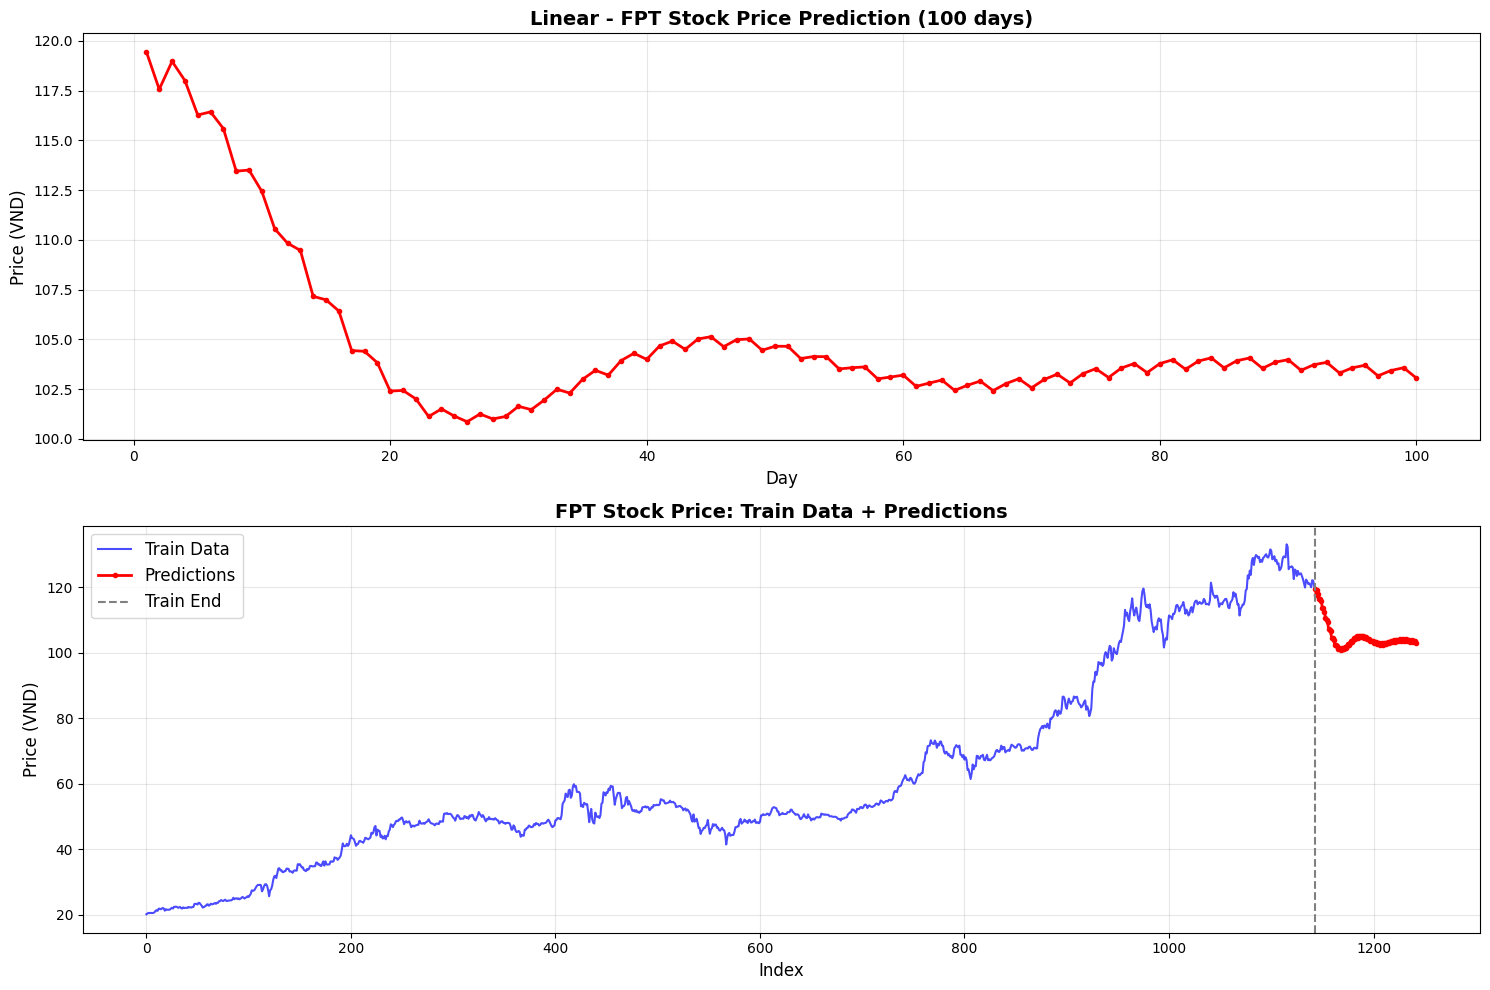

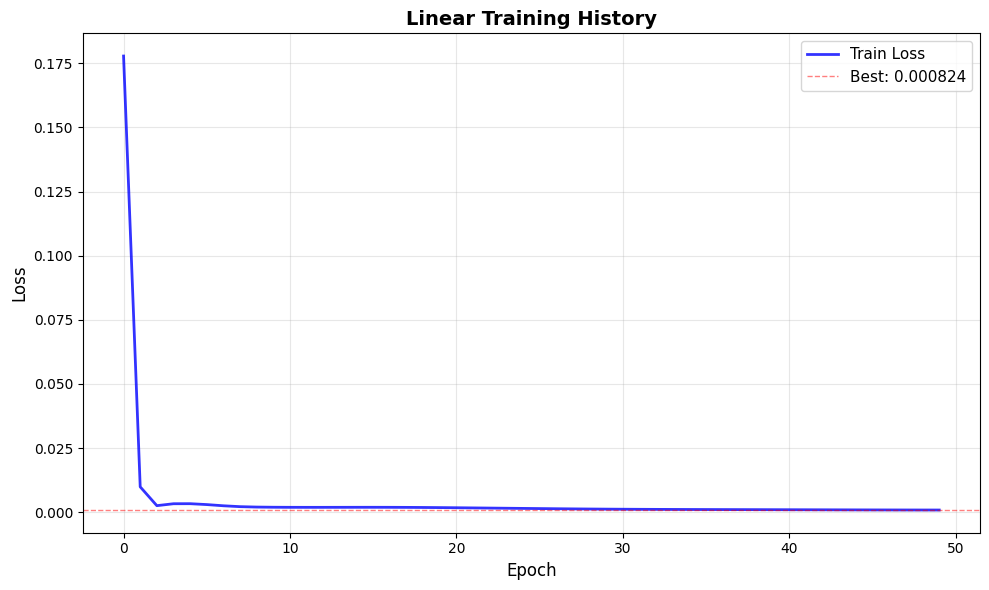

In [ ]:
# ============================================
# 1. PREDICTIONS PLOT
# ============================================

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

prediction_ids = list(range(1, TOTAL_PREDICT_DAYS + 1))

# Plot 1: Predictions only
axes[0].plot(prediction_ids, predictions_close, linewidth=2, color='red', marker='o', markersize=3)
axes[0].set_title(f'Linear - FPT Stock Price Prediction ({TOTAL_PREDICT_DAYS} days)',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day', fontsize=12)
axes[0].set_ylabel('Price (VND)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Train + Predictions
last_train_idx = len(df_train)
axes[1].plot(range(len(df_train)), df_train['close'],
             linewidth=1.5, color='blue', alpha=0.7, label='Train Data')
axes[1].plot(range(last_train_idx, last_train_idx + TOTAL_PREDICT_DAYS), predictions_close,
             linewidth=2, color='red', marker='o', markersize=3, label='Predictions')
axes[1].axvline(last_train_idx, color='gray', linestyle='--', linewidth=1.5, label='Train End')
axes[1].set_title('FPT Stock Price: Train Data + Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Index', fontsize=12)
axes[1].set_ylabel('Price (VND)', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# 2. TRAINING HISTORY - LINEAR
# ============================================

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(linear_history['train_losses'], label='Train Loss', linewidth=2, alpha=0.8, color='blue')
ax.axhline(y=min(linear_history['train_losses']), color='r',
           linestyle='--', linewidth=1, alpha=0.5,
           label=f'Best: {min(linear_history["train_losses"]):.6f}')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Linear Training History', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Create submission DataFrame
prediction_ids = list(range(1, TOTAL_PREDICT_DAYS + 1))
submission_df = pd.DataFrame({
    'id': prediction_ids,
    'close': predictions_close
})

# Save to CSV
output_filename = 'submission.csv'
submission_df.to_csv(output_filename, index=False)

print(f"\n✅ File saved: {output_filename}")
print(f"   Final training loss: {linear_history['train_losses'][-1]:.6f}")
print(f"   Predicted price range: {predictions_close.min():.2f} - {predictions_close.max():.2f}")
print(f"\n   First 5 rows:\n{submission_df.head()}")
print(f"\n   Last 5 rows:\n{submission_df.tail()}")



✅ File saved: submission.csv
   Final training loss: 0.000824
   Predicted price range: 100.87 - 119.45

   First 5 rows:
   id       close
0   1  119.451784
1   2  117.567714
2   3  118.971907
3   4  118.009833
4   5  116.279479

   Last 5 rows:
     id       close
95   96  103.703600
96   97  103.170680
97   98  103.437247
98   99  103.578951
99  100  103.055414
